In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
from nltk import sent_tokenize
# from pysummarization.nlpbase.auto_abstractor import AutoAbstractor
# from pysummarization.tokenizabledoc.simple_tokenizer import SimpleTokenizer
# from pysummarization.abstractabledoc.top_n_rank_abstractor import TopNRankAbstractor

In [65]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

<h3>Load in database

In [2]:
db = 'all-the-news.db'

In [3]:
cnx = sqlite3.connect(db)

In [4]:
df = pd.read_sql_query("SELECT * FROM longform", cnx)

<h3>Preview of DF

In [5]:
df.head()

,id,title,author,date,content,year,month,publication,category,digital,section,url
0,1,Agent Cooper in Twin Peaks is the audience: on...,\nTasha Robinson\n,2017-05-31,And never more so than in Showtime’s new...,2017,5,Verge,Longform,1.0,None,None
1,2,"AI, the humanity!",\nSam Byford\n,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017,5,Verge,Longform,1.0,None,None
2,3,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,Super Deluxe built a weird internet empi...,2017,5,Verge,Longform,1.0,None,None
3,4,How Anker is beating Apple and Samsung at thei...,\nNick Statt\n,2017-05-22,Steven Yang quit his job at Google in th...,2017,5,Verge,Longform,1.0,None,None
4,5,Tour Black Panther’s reimagined homeland with ...,\nKwame Opam\n,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017,5,Verge,Longform,1.0,None,None


In [7]:
df.shape

(204135, 12)

In [8]:
#clean up authors names
df.author = df.author.str.strip('\n')

In [9]:
#check that it worked
df.head()

,id,title,author,date,content,year,month,publication,category,digital,section,url
0,1,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,2017-05-31,And never more so than in Showtime’s new...,2017,5,Verge,Longform,1.0,None,None
1,2,"AI, the humanity!",Sam Byford,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017,5,Verge,Longform,1.0,None,None
2,3,The Viral Machine,Kaitlyn Tiffany,2017-05-25,Super Deluxe built a weird internet empi...,2017,5,Verge,Longform,1.0,None,None
3,4,How Anker is beating Apple and Samsung at thei...,Nick Statt,2017-05-22,Steven Yang quit his job at Google in th...,2017,5,Verge,Longform,1.0,None,None
4,5,Tour Black Panther’s reimagined homeland with ...,Kwame Opam,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017,5,Verge,Longform,1.0,None,None


In [9]:
#cut down columns
df = df[['title', 'author', 'content', 'year', 'month', 'category']]

In [10]:
#check for null values
df.isnull().sum()

title           0
author      32135
content     12954
year        12603
month       12603
category    35422
dtype: int64

In [11]:
#drop all rows where there is no article text
df.dropna(subset=['content'], inplace = True)

In [12]:
#check new shape of df
df.shape

(191181, 6)

In [13]:
#verify no null values in content column
df.isnull().sum()

title           0
author      20502
content         0
year         5518
month        5518
category    27703
dtype: int64

In [14]:
#view counts of article categories
df.groupby('category').title.count()

category
Book Reviews       20
Exclusive         214
Longform          137
Reports           854
broadcast       18672
business         8344
general         52152
newspaper       60365
radio           12001
wire            10719
Name: title, dtype: int64

In [15]:
#create new column for the character length of each article
df['len_article'] = df.content.str.len()

In [16]:
#drop rows where article is <2,500 or >15,000 characters
df = df[(df.len_article >= 2500) & (df.len_article <= 15000)]

In [17]:
df.head()

,title,author,content,year,month,category,len_article
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,And never more so than in Showtime’s new...,2017,5,Longform,12219
1,"AI, the humanity!",Sam Byford,AlphaGo’s victory isn’t a defeat for hum...,2017,5,Longform,11068
6,Massive attack,Colin Lecher,How a weapon against war became a weapon...,2017,4,Longform,14088
9,Brain drain,Casey Newton,Genius quietly laid off a bunch of its e...,2017,3,Longform,12170
32,Facebook takes flight,Casey Newton,Inside the test flight of Facebook’s fir...,2016,7,Longform,11967


In [18]:
#check new shape after dropping additional rows
df.shape

(128946, 7)

In [19]:
#preview df
#df.head()

,title,author,content,year,month,category,len_article
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,And never more so than in Showtime’s new...,2017,5,Longform,12219
1,"AI, the humanity!",Sam Byford,AlphaGo’s victory isn’t a defeat for hum...,2017,5,Longform,11068
6,Massive attack,Colin Lecher,How a weapon against war became a weapon...,2017,4,Longform,14088
9,Brain drain,Casey Newton,Genius quietly laid off a bunch of its e...,2017,3,Longform,12170
32,Facebook takes flight,Casey Newton,Inside the test flight of Facebook’s fir...,2016,7,Longform,11967


In [24]:
from gensim.summarization.summarizer import summarize

In [25]:
#create try/accept function to take care of edge case articles
#use gensim summarizer for baseline summary model
def gensim_summarizer(x, ratio_):
    try:
        return summarize(x, ratio = ratio_)
    except:
        return ''

In [120]:
#test the gensim_summarizer on subset of data
#test_df = df.iloc[:10]
#test_df['gensim_summary'] = test_df.content.apply(lambda x : gensim_summarizer(x, ratio_ = .05))

In [121]:
#verify that it worked
#test_df

In [39]:
#apply gensim_summarizer function to each row of full dataframe
df['gensim_summary'] = df.content.apply(lambda x : gensim_summarizer(x, ratio_ = .05))

In [119]:
#check that it worked
#df.head(100)

In [122]:
#CHECKPOINT --- save to csv --- NOT NECESSARY IF YOU ARE RUNNING THE WHOLE NOTEBOOK AT ONCE
#df.to_csv('full_df_with_gensim_summaries.csv')

In [7]:
#CHECKPOINT --- reload in csv if using the checkpoint
df = pd.read_csv('full_df_with_gensim_summaries.csv')

In [8]:
df.shape

(97064, 12)

In [125]:
df = df[df.gensim_summary.str.len() >= 1]

In [126]:
df.shape

(97064, 11)

In [127]:
#save to csv
df.to_csv('full_df_with_gensim_summaries.csv')

In [129]:
#drop unnecessary columns when loading in csv
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis = 1, inplace = True)

In [130]:
#preview
#df.head()

,title,author,content,year,month,category,len_article,gensim_summary
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,And never more so than in Showtime’s new...,2017.0,5.0,Longform,12219,"In the second season finale, back in 1991, the..."
1,"AI, the humanity!",Sam Byford,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Longform,11068,When speaking to DeepMind and Google developer...
2,Massive attack,Colin Lecher,How a weapon against war became a weapon...,2017.0,4.0,Longform,14088,International visitors for the event are commo...
3,Brain drain,Casey Newton,Genius quietly laid off a bunch of its e...,2017.0,3.0,Longform,12170,"In a post on the Genius blog at the time, co-f..."
4,Facebook takes flight,Casey Newton,Inside the test flight of Facebook’s fir...,2016.0,7.0,Longform,11967,But if your goal is to stay in the air for a l...


<h3>EDA on full dataframe

In [132]:
df.author.value_counts().describe()

count    17848.000000
mean         5.200134
std         15.872180
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        647.000000
Name: author, dtype: float64

There are 17,848 unique authors in the dataframe which is quite diverse. The average author has contributed about 5 articles to the dataframe. The top author (Associated Press) has contributed 647 articles which is to be expected since it's a combination of many writers. This is also the case for a number of the other top contributing authors.

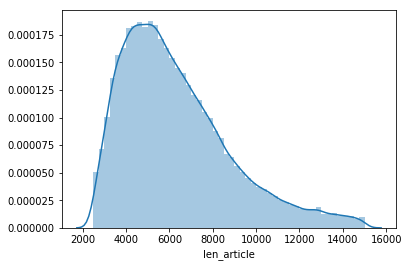

In [134]:
sns.distplot(df.len_article)

In [135]:
print('mean:', df.len_article.mean())
print('std:', df.len_article.std())
print('max:', df.len_article.max())
print('min:', df.len_article.min())

mean: 6335.110957718619
std: 2518.2000609532097
max: 14999
min: 2500


In [136]:
df.shape

(97064, 8)

The average article in the dataframe is roughly 6,335 characters in length. Taking a generous assumption that the average word is 10 characters in length (this can help account for spaces and punctuation), the average article is roughly 633 words long. 

After cutting out articles with greater than 15k words and less than 2.5k words, we are left with a dataframe composed of just over 97k articles. 

In [153]:
df.month.value_counts()

3.0     11277
1.0     10482
2.0     10351
4.0      9803
10.0     9158
6.0      8463
5.0      8343
12.0     6500
11.0     6437
9.0      5445
8.0      5381
7.0      5063
Name: month, dtype: int64

In [88]:
#create new df to preserve original data 
shortened_df = pd.read_csv('df_with_gensim_summaries.csv')

In [89]:
#drop columns
shortened_df = shortened_df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'author', 
                                  'year', 'month', 'len_article'], axis = 1)

In [90]:
#create column for first 100 words
shortened_df['split_words'] = shortened_df['content'].str.split()
shortened_df['first_100_words'] = shortened_df['split_words'].apply(lambda x: x[:100])

In [91]:
#rejoin the words in first 100
shortened_df['first_100'] = shortened_df['first_100_words'].apply(lambda x: ' '.join(x))

In [103]:
#drop unnecessary columns
#shortened_df = shortened_df.drop(['split_words', 'first_100_words'], axis = 1)

In [100]:
#tokenize each sentence in the content column
shortened_df['sent_tokenized'] = shortened_df.content.apply(lambda x: sent_tokenize(x, language = 'en'))

In [104]:
#check that it worked
#shortened_df.sent_tokenized[0]

In [19]:
#update saved csv
shortened_df.to_csv('full_df_with_gensim_summaries.csv')

NameError: name 'shortened_df' is not defined

In [113]:
#shortened_df.drop(['Unnamed: 0.1.1'], axis = 1, inplace = True)

In [114]:
#preview
shortened_df.head()

,title,content,category,gensim_summary,first_100,sent_tokenized
0,Agent Cooper in Twin Peaks is the audience: on...,And never more so than in Showtime’s new...,Longform,"In the second season finale, back in 1991, the...",And never more so than in Showtime’s new serie...,[ And never more so than in Showtime’s ne...
1,"AI, the humanity!",AlphaGo’s victory isn’t a defeat for hum...,Longform,When speaking to DeepMind and Google developer...,AlphaGo’s victory isn’t a defeat for humans — ...,[ AlphaGo’s victory isn’t a defeat for hu...
2,Massive attack,How a weapon against war became a weapon...,Longform,International visitors for the event are commo...,How a weapon against war became a weapon again...,[ How a weapon against war became a weapo...
3,Brain drain,Genius quietly laid off a bunch of its e...,Longform,"In a post on the Genius blog at the time, co-f...",Genius quietly laid off a bunch of its enginee...,[ Genius quietly laid off a bunch of its ...
4,Facebook takes flight,Inside the test flight of Facebook’s fir...,Longform,But if your goal is to stay in the air for a l...,Inside the test flight of Facebook’s first int...,[ Inside the test flight of Facebook’s fi...


<h3>EDA CONTINUED ON SHORTENED DF

In [21]:
shortened_df = pd.read_csv('full_df_with_gensim_summaries.csv')

FileNotFoundError: [Errno 2] File b'full_df_with_gensim_summaries.csv' does not exist: b'full_df_with_gensim_summaries.csv'

[Text(0, 0, 'Longform'),
 Text(0, 0, 'Reports'),
 Text(0, 0, 'Exclusive'),
 Text(0, 0, 'Book Reviews'),
 Text(0, 0, 'newspaper'),
 Text(0, 0, 'general'),
 Text(0, 0, 'broadcast'),
 Text(0, 0, 'business'),
 Text(0, 0, 'radio'),
 Text(0, 0, 'wire')]

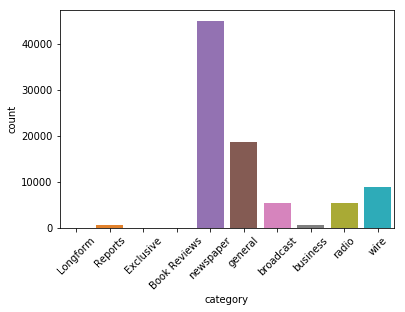

In [118]:
ax = sns.countplot(x= 'category', data=shortened_dftened_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [6]:
df.loc[df['category'] == 'radio']

,id,title,author,date,content,year,month,publication,category,digital,section,url
126586,160641,"Thanks To Russia, 2016 Isn't Really Going To E...",Ron Elving,2016-12-31,"[In the Washington of 2016, even when the poli...",2016,12,NPR,radio,3.0,None,http://www.npr.org/2016/12/31/507596704/for-tr...
126587,160642,Trump Tweets Give A Glimpse Into Foreign Polic...,Jessica Taylor,2016-12-28,[President-elect Donald Trump has used Twitter...,2016,12,NPR,radio,3.0,None,http://www.npr.org/2016/12/28/507284226/trump-...
126588,160643,"As U.S. Confronts Russia, Trump's Admiration O...",Arnie Seipel,2016-12-30,[President-elect Donald Trump is unabashedly p...,2016,12,NPR,radio,3.0,None,http://www.npr.org/2016/12/30/507584595/as-u-s...
126589,160644,Putin Says Russia Won't Expel Diplomats In Res...,Camila Domonoske,2016-12-30,"[Updated at 2:50 p.m. ET, Russian President Vl...",2016,12,NPR,radio,3.0,thetwo-way,http://www.npr.org/sections/thetwo-way/2016/12...
126590,160645,(Some Of) Our Favorite Visual Stories of 2016,Ariel Zambelich,2016-12-31,"[From photography, illustration and video, to ...",2016,12,NPR,radio,3.0,None,http://www.npr.org/2016/12/31/507590770/-some-...
126591,160646,A Skeptic Fact-Checks Yoga's Health Claims And...,Ann Finkbeiner,2016-12-31,[I did not want to join yoga class. I hated th...,2016,12,NPR,radio,3.0,health-shots,http://www.npr.org/sections/health-shots/2016/...
126592,160647,"From Psychedelics To Alzheimer's, 2016 Was A G...",Bret Stetka,2016-12-31,[With a president-elect who has publicly suppo...,2016,12,NPR,radio,3.0,health-shots,http://www.npr.org/sections/health-shots/2016/...
126593,160648,"Living In America 101: When Refugees Arrive, W...",Gabrielle Emanuel,2016-12-31,"[I was standing by the airport exit, debating ...",2016,12,NPR,radio,3.0,ed,http://www.npr.org/sections/ed/2016/12/31/4840...
126594,160649,"When Bats Squeak, They Tend To Squabble",NPR Staff,2016-12-31,"[If movies were trying to be more realistic, p...",2016,12,NPR,radio,3.0,None,http://www.npr.org/2016/12/31/507609012/when-b...
126595,160650,"By Returning To Farming's Roots, He Found His ...",Dan Charles,2016-12-31,"[Eighteen years ago, on New Year's Eve, David ...",2016,12,NPR,radio,3.0,thesalt,http://www.npr.org/sections/thesalt/2016/12/31...


In [143]:
newspaper = df.loc[df['category'] == 'newspaper']

In [145]:
newspaper.shape

(45089, 8)

In [149]:
newspaper.author.value_counts()

ax2= sns.countplot(x= 'category', data=shortened_dftened_df)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

Charles McDermid                                            253
Associated Press                                            249
Editorial Board                                             222
Mike McPhate                                                220
Karen Zraick and Sandra Stevenson                           195
Dana Milbank                                                184
Vanessa Friedman                                            163
Sam Roberts                                                 162
The New York Times                                          140
Ben Brantley                                                128
Richard Sandomir                                            126
Adam Liptak                                                 125
James Poniewozik                                            121
Chris Cillizza                                              121
Neil Genzlinger                                             118
Philip Bump                             

In [146]:
general = df.loc[df['category'] == 'general']

In [148]:
general.shape

(18738, 8)

In [151]:
general.author.value_counts()

John Hayward                                          451
Matthew Yglesias                                      260
David A. Graham                                       256
Joel B. Pollak                                        246
German Lopez                                          233
Bob Price                                             227
Aaron Klein                                           224
Frances Martel                                        219
Breitbart News                                        211
Dara Lind                                             187
Brad Plumer                                           179
Julia Belluz                                          174
Todd VanDerWerff                                      173
Rosa Inocencio Smith                                  172
Jeff Stein                                            168
Zack Beauchamp                                        162
Matthew Boyle                                         160
Andrew Prokop 